In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

In [2]:
def plot_trace_spacetime(jobs, num_nodes):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)+5
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100,50))
    total_gpus = num_nodes * GPUS_PER_NODE
    for j_idx, job in enumerate(jobs):
        allocated_gpus = job.allocated_gpus
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx + node_gpu_idx)
#                 print(job.idx)
#                 print(len(colors))
                ax.barh(gpu_idx,
                        width=job.runtime,
                        edgecolor='black',
                        height=1.0,
                        left=job.start,
                        align='edge',
                        color=colors[job.idx])
    import math
    for i in range(total_gpus+1):
        multiplier = math.ceil(num_nodes/32)
        if (i+1)%GPUS_PER_NODE==1:
            plt.axhline(y=i+1,linewidth=8/multiplier, color='brown')
        else:
            plt.axhline(y=i+1,linewidth=1/multiplier, color='black', linestyle='--')
    plt.ylim(bottom=1, top=total_gpus+1)
    plt.xlim(right=1.5*max([j.arrival for j in jobs]))
    plt.axvline(x=max([j.arrival for j in jobs]), color='black', linewidth=5)
    plt.tight_layout()
    plt.show()
    
def visualize_jobs(jobs, mode='all'):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    x = [(j.arrival, j.deadline) for j in jobs]
    fig, ax = plt.subplots(figsize=(100,50))
    
    count=0
    for i,evt in enumerate(x):
        if mode=='all':
            mask = 1
        elif mode=='cloud':
            if jobs[i].start is None:
                mask=1
            else:
                mask=0
        elif mode=='local':
            if jobs[i].start is None:
                mask=0
            else:
                mask=1
#         ax.barh(count,
#                 width=(evt[1]-evt[0]),
#                 edgecolor='black' if mask else None,
#                 height=1.0*jobs[i].num_gpus,
#                 left=evt[0],
#                 align='edge',
#                 color=colors[i] if mask else 'grey')
        ax.barh(count,
                width=mask*(evt[1]-evt[0]),
                edgecolor='black' if mask else None,
                height=1.0*jobs[i].num_gpus,
                left=evt[0],
                align='edge',
                color=colors[i] if mask else None)

        count+= jobs[i].num_gpus 
    ax.get_yaxis().set_visible(False)
    plt.xlabel('Time Quantums')
    plt.show()

In [3]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'size': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    for key, finished_jobs in simulator_results.items():
        alg, num_nodes = key.split('-')
        num_nodes = int(num_nodes)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        for j in finished_jobs:
            if j.start is None:
                cloud_cost += j.cost
                if hasattr(j, 'state') and j.state == 'TIMEOUT-CLOUD':
                    pass
                else:
                    total_waiting_time += j.deadline - j.runtime - j.arrival
            else:
                total_waiting_time += j.start - j.arrival
        avg_waiting_time = total_waiting_time / len(finished_jobs)
        df = pd.DataFrame(data={'alg': [alg], 'size': [num_nodes], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_waiting_cost_graph(results_df, title=None):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
        a2 = grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()  

1


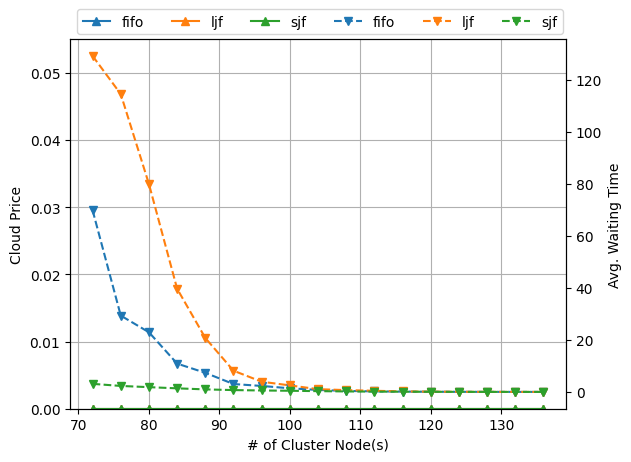

1.1


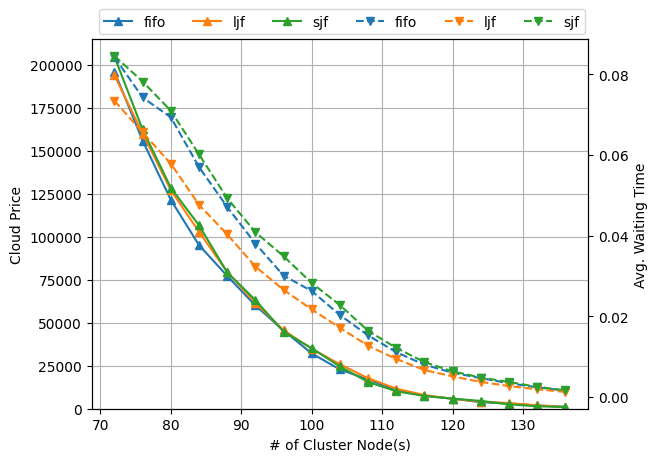

1.25


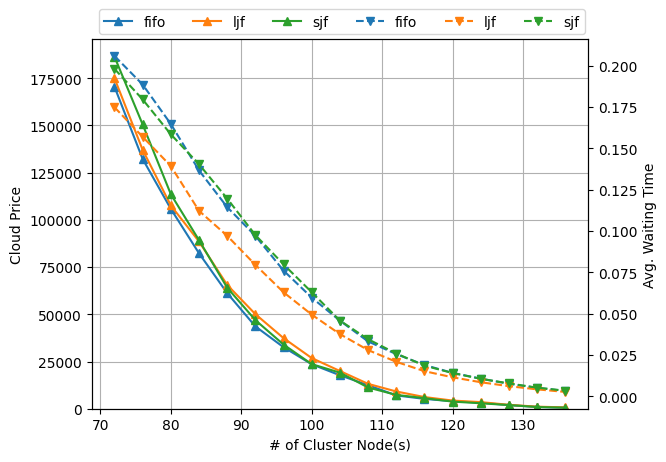

1.5


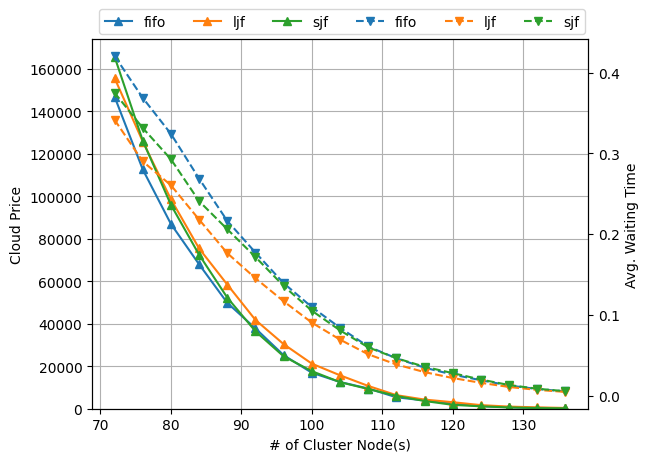

1.8


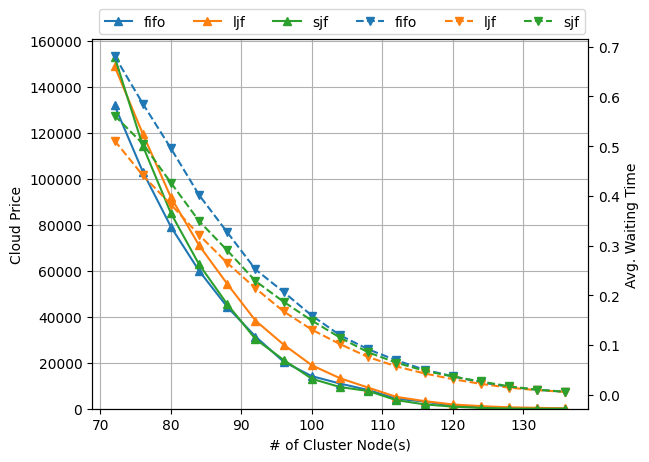

2


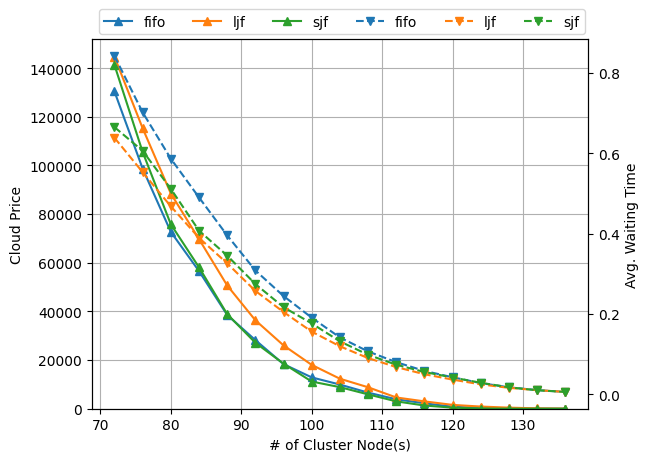

3


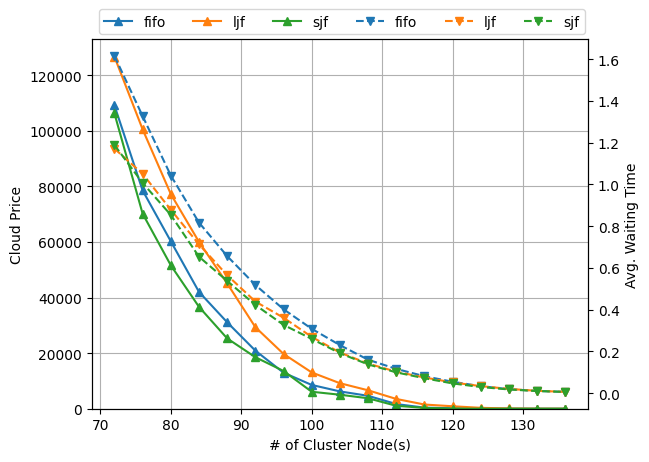

5


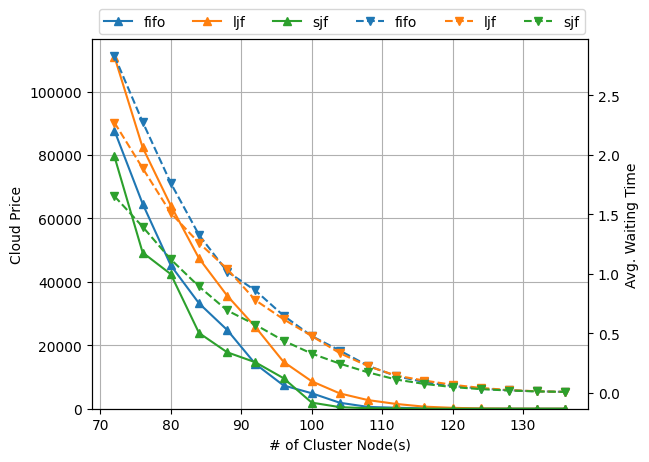

10


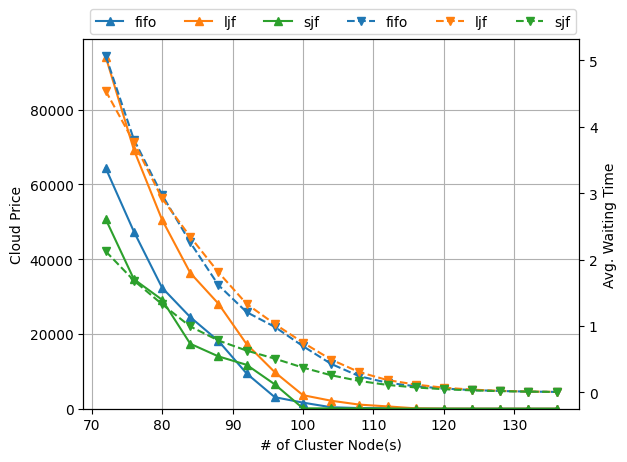

1000000000.0


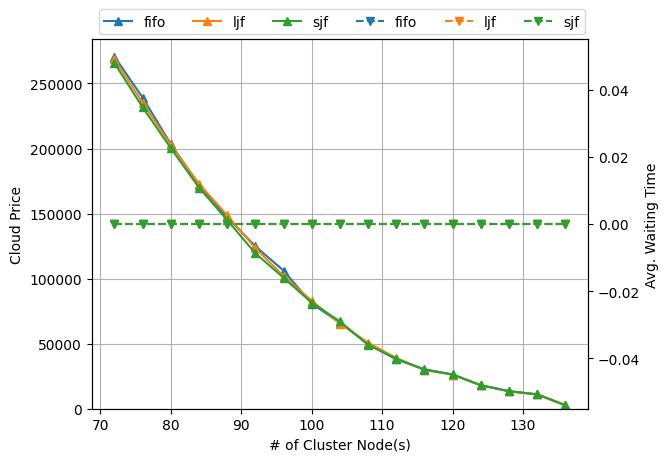

In [12]:
hybrid_results = {}
hybrid_results_df = None
for ddl in [1, 1.1, 1.25, 1.5, 1.8, 2, 3, 5, 10, 1e9]:
    print(ddl)
    if ddl == 1e9:
        ddl = int(ddl)
    file = open(f'logs/vjw_philly_{ddl}_cont.log', 'rb')
    hybrid_results[ddl] = pickle.load(file)
    hybrid_results_df = create_results_df(hybrid_results[ddl])
    hybrid_results_df["deadline"] = ddl
    if ddl == 1e9:
        hybrid_results_df['waiting_time'] = 0
    plot_waiting_cost_graph(hybrid_results_df)

In [35]:
hybrid_results_df = pd.DataFrame()
for ddl in [1, 1.1, 1.25, 1.5, 1.8, 2, 3, 5, 10, 1e9]:
    temp_df = create_results_df(hybrid_results[ddl])
    temp_df["deadline"] = ddl
    if ddl == 1:
        temp_df['waiting_time'] = 0
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

    

In [34]:
print(hybrid_results.keys())
temp = hybrid_results[int(1e9)]
temp1 = hybrid_results[1]

hybrid_results[1] = temp
hybrid_results[int(1e9)] = temp1

dict_keys([1, 1.1, 1.25, 1.5, 1.8, 2, 3, 5, 10, 1000000000])


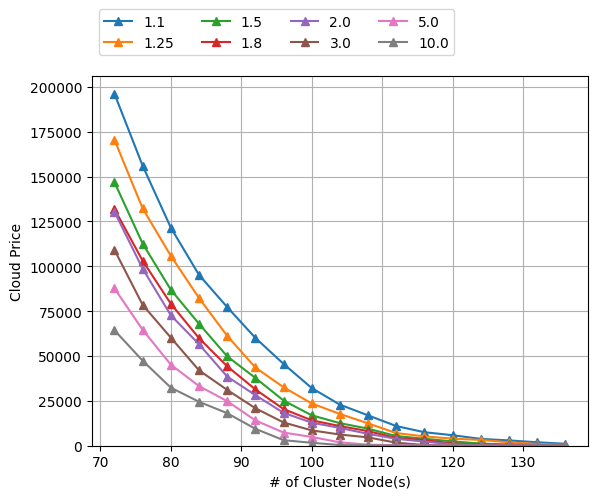

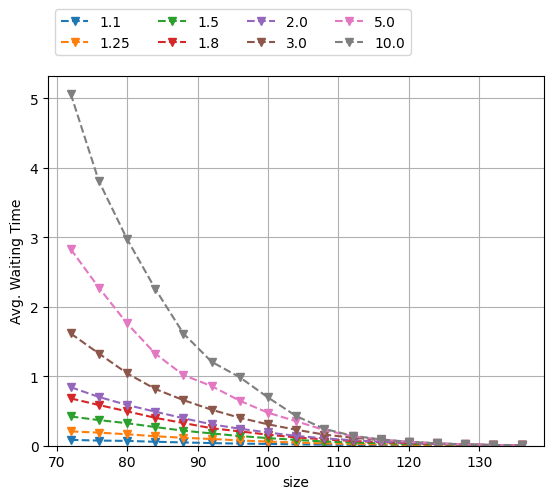

In [37]:
def plot_waiting_cost_graph_diff_deadline(results_df, alg='fifo', title=None):
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg]
    results_df = results_df[results_df['deadline'] != 1] 
    results_df = results_df[results_df['deadline'] != 1e9] 
    for idx, (label, grp) in enumerate(results_df.groupby('deadline')):
        a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels)/2, \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()
    
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg] 
    #results_df = results_df[results_df['deadline'] != 1] 
    #results_df = results_df[results_df['deadline'] != 1e9] 
    for idx, (label, grp) in enumerate(results_df.groupby('deadline')):
        a2 = grp.plot(x = 'size', y = 'waiting_time', ax = ax, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels)/2, \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()

plot_waiting_cost_graph_diff_deadline(hybrid_results_df)
#plot_waiting_cost_graph_diff_deadline(hybrid_results_df, alg='ljf')

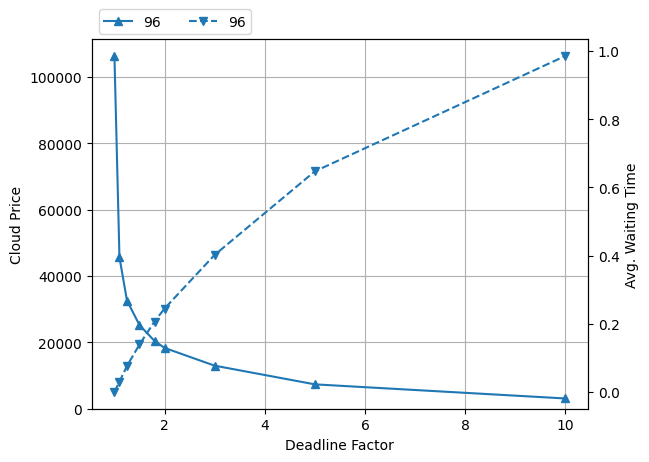

In [45]:
def plot_deadline_constant_nodes(results_df, num_nodes=96, alg='fifo'):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    results_df = results_df[results_df['size'] == num_nodes] 
    results_df = results_df[results_df['deadline'] != 1e9] 
    #results_df = results_df[results_df['deadline'] != 1] 
    results_df = results_df[results_df['alg'] == alg] 
    for idx, (label, grp) in enumerate(results_df.groupby('size')):
        a1 = grp.plot(x = 'deadline', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='Deadline Factor', \
                ylabel='Cloud Price')
        a2 = grp.plot(x = 'deadline', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()

plot_deadline_constant_nodes(hybrid_results_df, num_nodes=96)

In [31]:
def plot_job_statistics(jobs, bins=None):
    jobs = copy.deepcopy(jobs)
    runtime = [j.runtime for j in jobs]
    if bins is None:
        bins = [0, 0.1, 1, 8, 24, 168, math.ceil(max(runtime))]
    
    counts = [0] * (len(bins)-1)
    costs = [0] * (len(bins)-1)
    runtime = [j.runtime for j in jobs]
    for job_idx, r in enumerate(runtime):
        for bin_idx in range(len(bins)-1):
            if r >= bins[bin_idx] and r < bins[bin_idx+1]:
                counts[bin_idx] +=1
                costs[bin_idx] += jobs[job_idx].cost

    fig, ax = plt.subplots()
    for idx, c in enumerate(counts):
        pps = ax.bar(f'[{bins[idx]},{bins[idx+1]})', height=c, edgecolor='black', align='center', label=f'[{bins[idx]},{bins[idx+1]})')
        for p in pps:
            height = p.get_height()
            ax.annotate('{}'.format(height),
              xy=(p.get_x() + p.get_width() / 2, height),
              xytext=(0, 2), # 3 points vertical offset
              textcoords="offset points",
              ha='center', va='bottom')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.xlabel('Job Runtimes (hr)')
    plt.ylabel('Count')
    plt.title('Job Runtime PDF')
    plt.show()
    
    
    fig, ax = plt.subplots()
    for idx, c in enumerate(costs):
        pps = ax.bar(f'[{bins[idx]},{bins[idx+1]})', height=c, edgecolor='black', align='center', label=f'[{bins[idx]},{bins[idx+1]})')
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    plt.xlabel('Job Runtimes (hr)')
    plt.ylabel('Cost')
    plt.title('Total Costs PDF')
    plt.show()
    

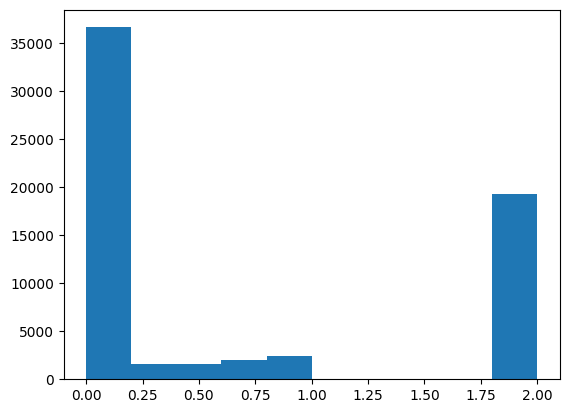

In [12]:
plot_job_waiting_time_distribution(hybrid_results[2]['fifo-88'], deadline=2, job_filter=lambda x: x.runtime <= 1.0)

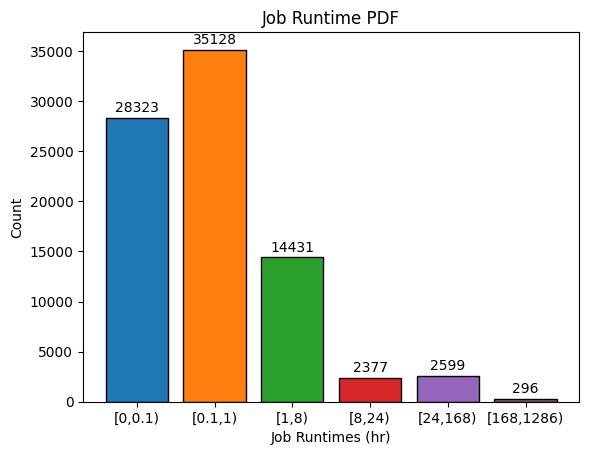

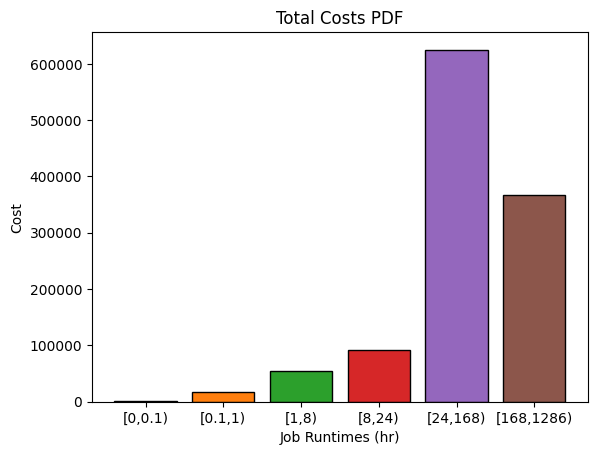

In [8]:
plot_job_statistics(hybrid_results[1.1]['fifo-88'])

In [47]:
def plot_run_statistics(jobs):
    jobs = copy.deepcopy(jobs)
    runtime = [j.runtime for j in jobs]
    bins = [0, 0.1, 1, 8, 24, 168, math.ceil(max(runtime))]
    
    # Plot total waiting hours as a function of jobs runtimes
    waiting_onprem = [0] * (len(bins)-1)
    waiting_cloud = [0] * (len(bins)-1)
    costs = [0] * (len(bins)-1)
    runtime = [j.runtime for j in jobs]
    for job_idx, r in enumerate(runtime):
        for bin_idx in range(len(bins)-1):
            if r >= bins[bin_idx] and r < bins[bin_idx+1]:
                if jobs[job_idx].start is None:
                    waiting_cloud[bin_idx] += jobs[job_idx].deadline - jobs[job_idx].runtime - jobs[job_idx].arrival
                    costs[bin_idx] += jobs[job_idx].cost
                else:
                    waiting_onprem[bin_idx] += jobs[job_idx].start - jobs[job_idx].arrival

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12.8, 4.8))
    ax = axes[0]
    for idx, c in enumerate(waiting_onprem):
        pps = ax.bar(f'[{bins[idx]},{bins[idx+1]})', height=c, \
                     edgecolor='black', align='center', color='#1f77b4', label=f'Local')
        pps = ax.bar(f'[{bins[idx]},{bins[idx+1]})', height=waiting_cloud[idx], bottom=c, \
                     edgecolor='black', align='center', color='#ff7f0e', label=f'Cloud')
    ax.legend(['Local', 'Cloud'])
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.set_xlabel('Job Runtimes (hr)')
    ax.set_ylabel('Cumulative Waiting Hours')
    ax.set_title('Total Waiting')

    ax = axes[1]
    for idx, c in enumerate(costs):
        pps = ax.bar(f'[{bins[idx]},{bins[idx+1]})', height=c, \
                     edgecolor='black', align='center', color='#1f77b4', label=f'Local')
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.set_xlabel('Job Runtimes (hr)')
    ax.set_ylabel('Cumulative Costs')
    ax.set_title('Total Costs')
    plt.show()

    
def plot_job_waiting_time_distribution(jobs, deadline, job_filter = None, include_cloud=True):
    jobs = copy.deepcopy(jobs)
    
    if not include_cloud:
        jobs = [j for j in jobs if j.start is not None]
    
    if job_filter:
        jobs = [j for j in jobs if job_filter(j)]
    
    waiting_time_percent = []
    for j in jobs:
        if j.start is None:
            waiting_time_percent.append(deadline)
        elif j.runtime == 0:
            waiting_time_percent.append(1)
        else:
            waiting_time_percent.append((j.start - j.arrival)/j.runtime)
    #print(waiting_time_percent)
    plt.hist(waiting_time_percent)
    plt.show()

fifo-72


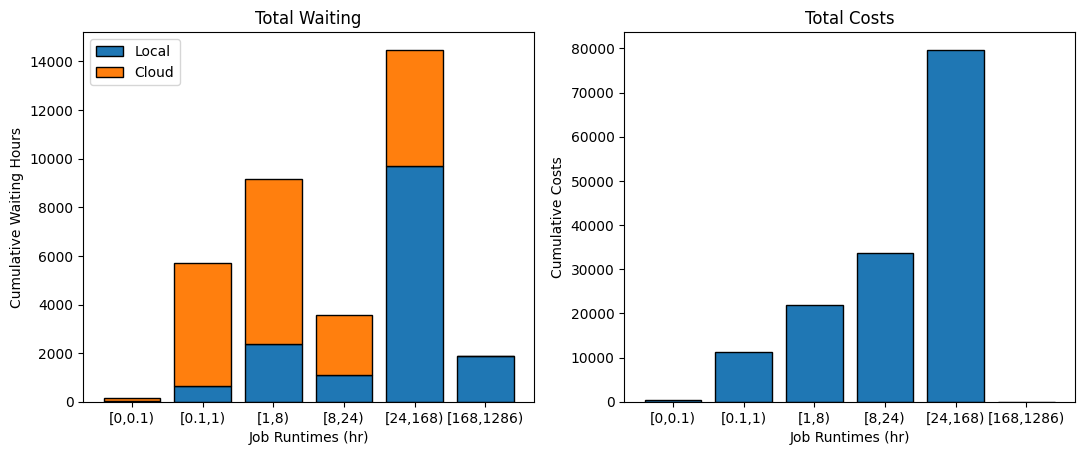

sjf-72


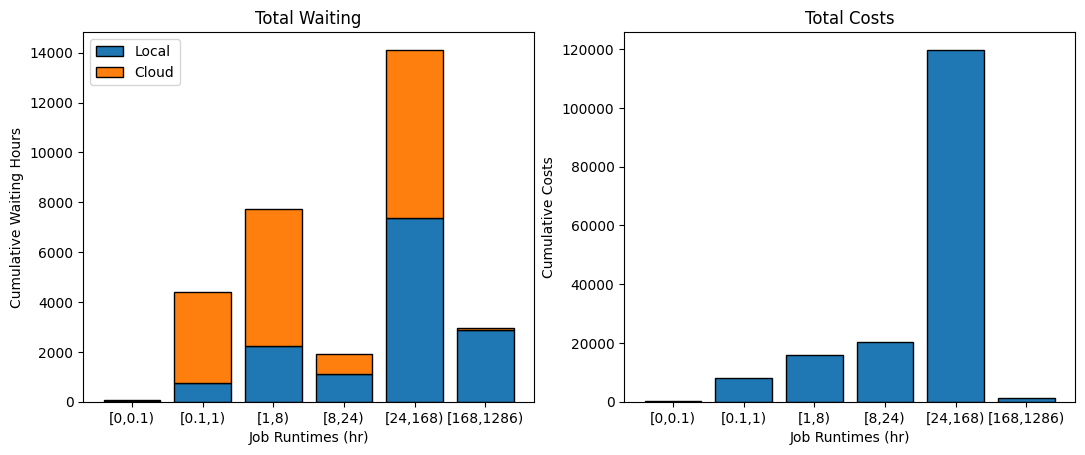

ljf-72


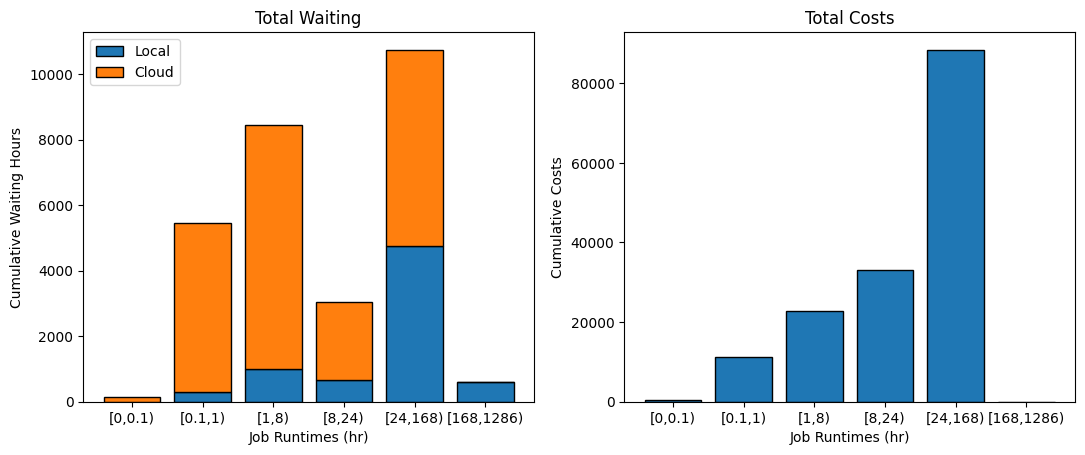

In [50]:
algs = ['fifo', 'sjf', 'ljf']
for alg in algs:
    run_str = f'{alg}-72'
    print(run_str)
    plot_run_statistics(hybrid_results[1.5][run_str])

0


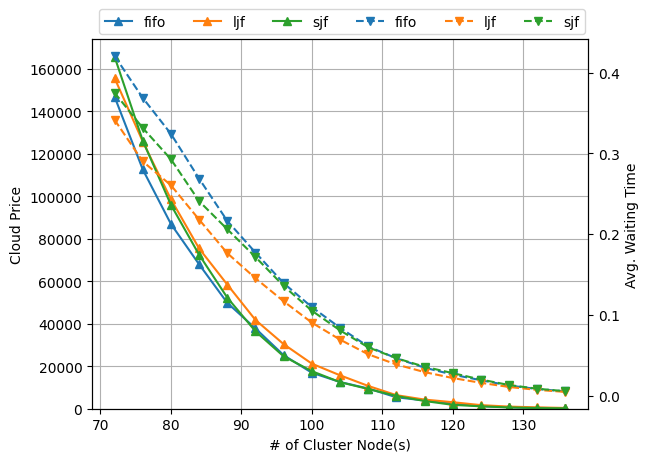

1


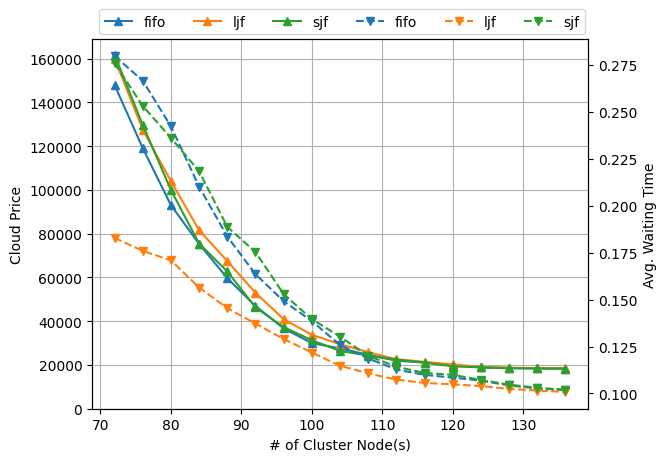

2


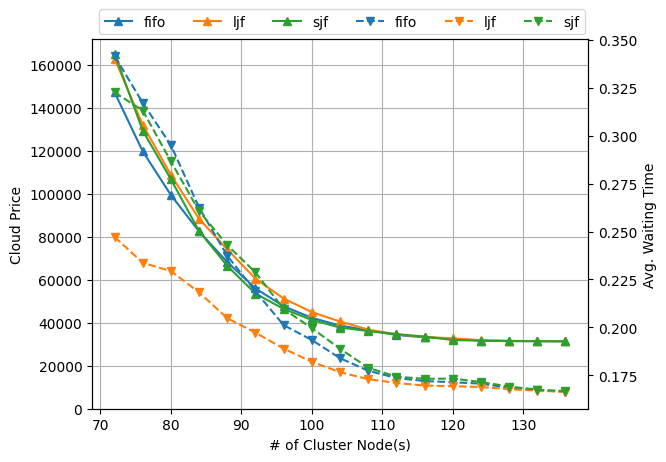

4


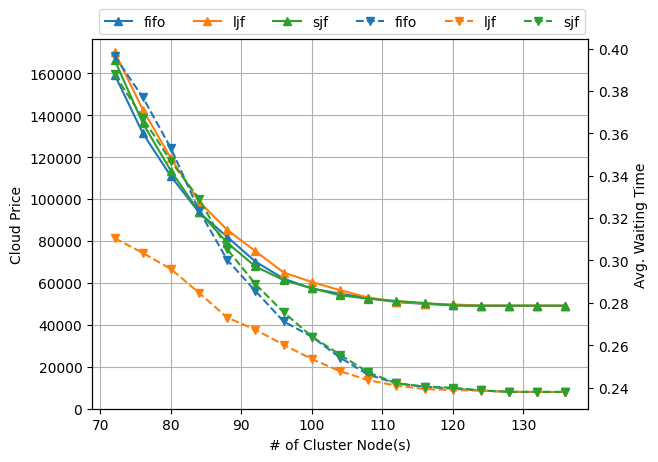

8


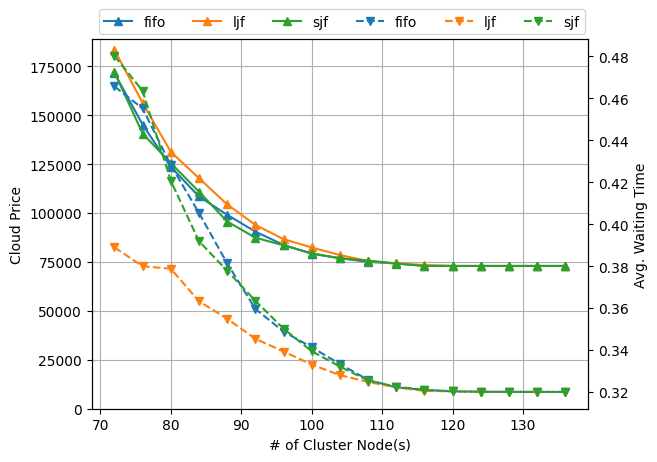

KeyError: 0

In [54]:
def create_thres_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'size': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    for key, finished_jobs in simulator_results.items():
        alg, num_nodes = key.split('-')
        num_nodes = int(num_nodes)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        for j in finished_jobs:
            if j.start is None:
                cloud_cost += j.cost
                if hasattr(j, 'state') and j.state == 'TIMEOUT-CLOUD':
                    pass
                else:
                    total_waiting_time += j.deadline - j.runtime - j.arrival
            else:
                total_waiting_time += j.start - j.arrival
        avg_waiting_time = total_waiting_time / len(finished_jobs)
        df = pd.DataFrame(data={'alg': [alg], 'size': [num_nodes], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    results_df['deadline'] = 1.5
    return results_df

def plot_waiting_cost_thres_graph(results_df, thres=0, title=None):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
        a2 = grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()  

hybrid_thres_results = {}
hybrid_thres_results_df = None
for thres in [0, 1, 2, 4, 8]:
    print(thres)
    file = open(f'logs/vjw_philly_1.5_{thres}_cont.log', 'rb')
    hybrid_thres_results[thres] = pickle.load(file)
    hybrid_thres_results_df = create_thres_results_df(hybrid_thres_results[thres])
    plot_waiting_cost_thres_graph(hybrid_thres_results_df)

    

In [55]:
hybrid_thres_results_df = pd.DataFrame()
for thres in [0, 1, 2, 4, 8]:
    temp_df = create_results_df(hybrid_thres_results[thres])
    temp_df['thres'] = thres
    hybrid_thres_results_df  = pd.concat([hybrid_thres_results_df , temp_df], ignore_index=True)

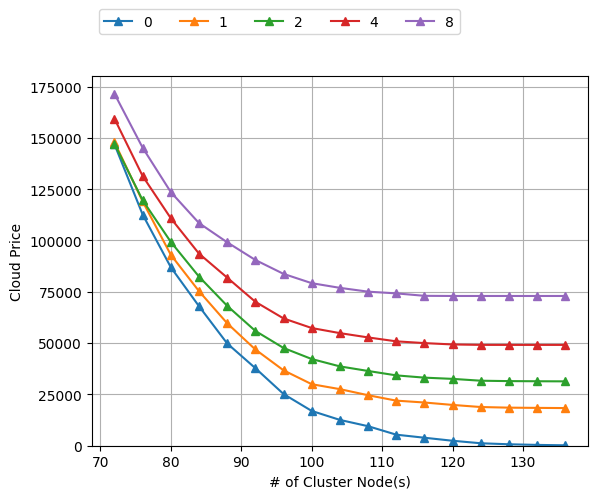

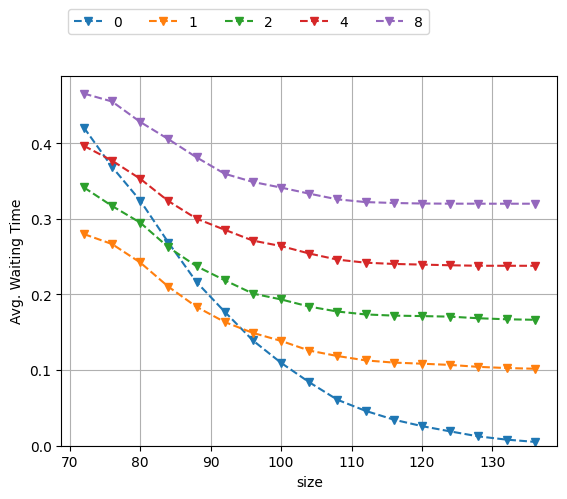

In [64]:
def plot_waiting_cost_graph_diff_thres_deadline(results_df, alg='fifo', title=None):
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg]

    for idx, (label, grp) in enumerate(results_df.groupby('thres')):
        a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()
    
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg] 
    for idx, (label, grp) in enumerate(results_df.groupby('thres')):
        a2 = grp.plot(x = 'size', y = 'waiting_time', ax = ax, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()

plot_waiting_cost_graph_diff_thres_deadline(hybrid_thres_results_df)

fifo-72


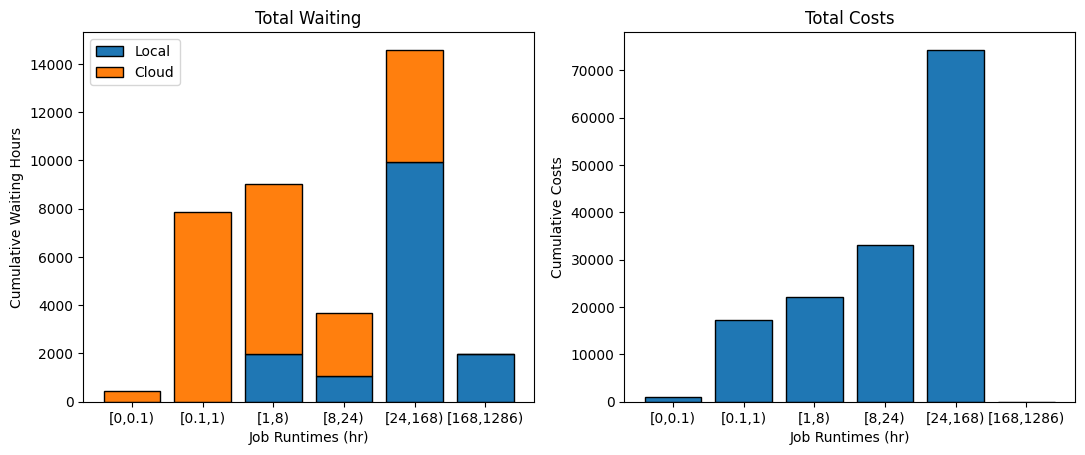

sjf-72


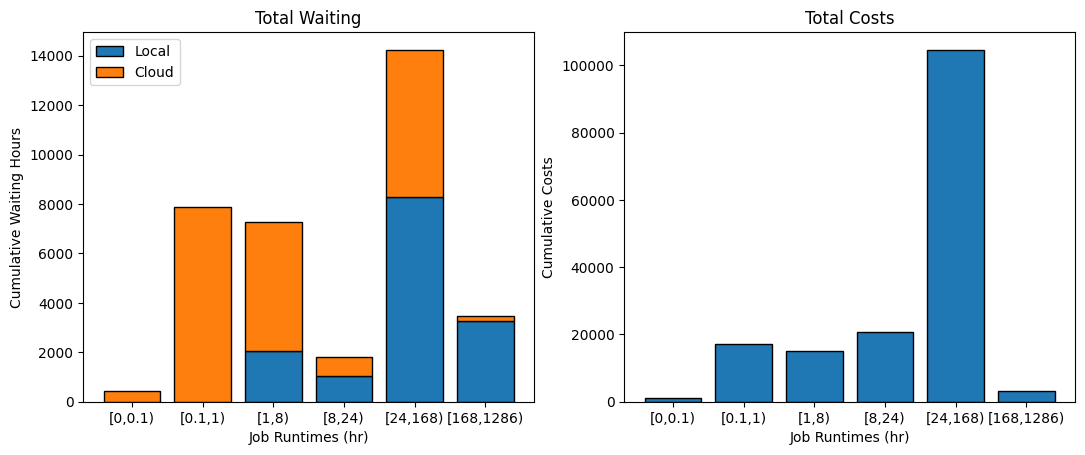

ljf-72


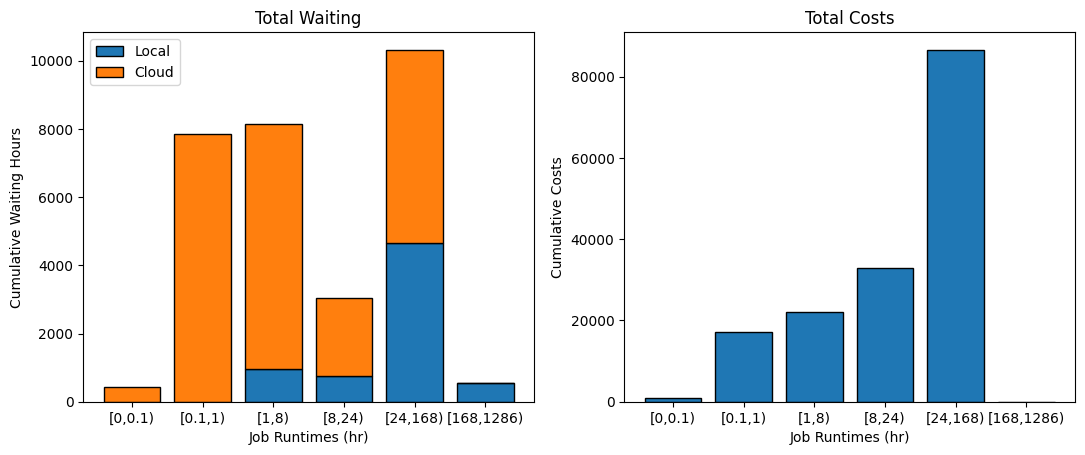

In [59]:
algs = ['fifo', 'sjf', 'ljf']
for alg in algs:
    run_str = f'{alg}-72'
    print(run_str)
    plot_run_statistics(hybrid_thres_results[1][run_str])